In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from numba import jit
from scipy.integrate import solve_ivp

In [40]:
size = (7, 2)

# Kuramoto Model

We're using $\alpha = 1.457$, $\kappa = 4.0$ and 512 oscillators.

In [453]:
def g(y, κ):
    return κ*np.exp(-κ*np.abs(y))/2

In [454]:
def periodic_distance(x1, x2, length=1):
    return np.minimum(np.abs(x1 - x2), length - np.abs(x1 - x2))

In [267]:
xx, xy = np.meshgrid(np.linspace(0, 1, 512), np.linspace(0, 1, 512))
g_solved = g(periodic_distance(xx, xy), 4)

In [268]:
@jit
def ϕ̇(t, ϕ):
    ϕx, ϕy = np.meshgrid(ϕ, ϕ)
    return - np.sum(g_solved*np.sin(ϕy - ϕx + 1.457), axis=1)/512

In [269]:
ϕ0 = 2*np.pi*np.random.rand(512) - np.pi

In [270]:
%%script false
%%time
kuramoto_sol = solve_ivp(ϕ̇, (0, 1000), ϕ0, t_eval=np.linspace(0, 1000, 100000), method="RK45")

CPU times: user 15.7 s, sys: 2.94 s, total: 18.6 s
Wall time: 11.9 s


In [12]:
def drop_phase(phase):
    return (phase + np.pi)%(2*np.pi) - np.pi

In [272]:
kuramoto_y = drop_phase(kuramoto_sol.y)

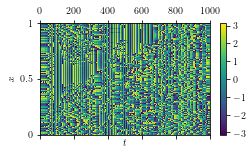

In [355]:
%%script false
plt.matshow(kuramoto_y, aspect="auto", origin="lower")
plt.colorbar(kuramoto_overhead_im, cax=kuramoto_overhead_ax)
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.gca().set_xticklabels(["$-200$", "$0$", "$200$", "$400$", "$600$", "$800$", "$1000$"])
plt.yticks([0, 256, 512], ["$0$", "$0.5$", "$1$"])
plt.colorbar()

plt.gcf().set_size_inches(3.8, 2, forward=True)
plt.savefig("../figure/kuramoto_overhead", dpi=700, bbox_inches="tight")

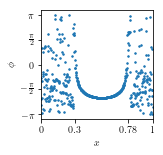

In [351]:
%%script false
plt.plot(np.linspace(0, 1, 512), kuramoto_y[:, 12000], ".", markersize=3)
plt.xlim([0, 1])
plt.xticks([0, 0.3, 0.78, 1], ["$0$", "$0.3$", "$0.78$", "$1$"])
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
plt.xlabel("$x$")
plt.ylabel(r"$\phi$")

plt.gcf().set_size_inches(2, 2, forward=True)

plt.savefig("../figure/kuramoto_snapshot", dpi=700, bbox_inches="tight")

# Abrams model

In [4]:
μ = 0.6
ν = 0.4
α = np.pi/2 - 0.05
n = 256
n2 = n//2

In [5]:
k = ν*np.ones([n, n])
k[:n2, :n2] = μ
k[n2:, n2:] = μ

In [6]:
@jit
def θ̇(t, θ):
    θx, θy = np.meshgrid(θ, θ)
    return -np.sum(k*np.sin(θy - θx - α), axis=1)/n2

In [7]:
θ0 = 2*np.pi*np.random.random(n) - np.pi

In [8]:
θ0 = np.hstack([0.5*np.random.rand(n2) - 0.25, 2*np.pi*np.random.rand(n2) - np.pi])

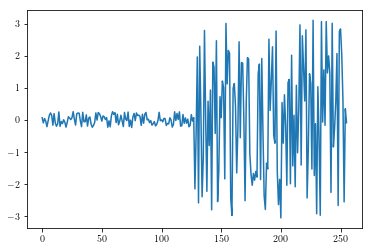

In [9]:
plt.plot(θ0)

In [10]:
%%time
abrams_sol = solve_ivp(θ̇, (0, 1000), θ0, max_step=0.01, method="RK45")

CPU times: user 15min 49s, sys: 13.3 s, total: 16min 2s
Wall time: 16min 41s


In [13]:
abrams_y = drop_phase(abrams_sol.y)

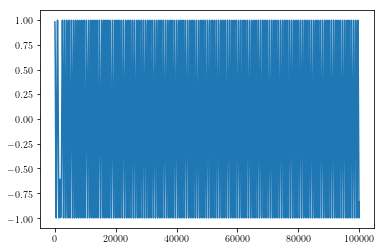

In [123]:
plt.plot(np.cos(abrams_y[0]))

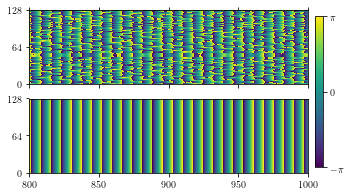

In [41]:
fig, [sync_ax, async_ax] = plt.subplots(2, 1, sharex=True, sharey=True)
im = async_ax.matshow(abrams_y[:128, 80000:], aspect="auto", origin="lower")
sync_ax.matshow(abrams_y[128:, 80000:], aspect="auto", origin="lower")

async_ax.set_xticks([0, 5000, 10000, 15000, 20000])
async_ax.set_xticklabels([800, 850, 900, 950, 1000])
async_ax.xaxis.set_ticks_position("bottom")

sync_ax.set_yticks([0, 64, 128])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=[-3.14, 0, 3.14])
cbar_ax.set_yticklabels(["$-\pi$", "$0$", "$\pi$"])

fig.set_size_inches(5, 3, forward=True)
plt.savefig("../figure/abrams_overhead", dpi=700, bbox_inches="tight")

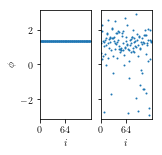

In [43]:
fig, [sync_ax, async_ax] = plt.subplots(1, 2, sharey=True)
sync_ax.plot(np.arange(0, 128, 1), abrams_y[:128, 79945], ".", markersize=2)
sync_ax.set_xlim([0, 128])
sync_ax.set_ylim([-np.pi, np.pi])
sync_ax.set_xlabel("$i$")
sync_ax.set_ylabel("$\phi$")
sync_ax.set_xticks([0, 64])

async_ax.plot(np.arange(0, 128, 1), abrams_y[128:, 79945], ".", markersize=2)
async_ax.set_xlim([0, 128])
async_ax.set_ylim([-np.pi, np.pi])
async_ax.set_xlabel("$i$")
async_ax.set_xticks([0, 64])

fig.set_size_inches(2, 2, forward=True)
plt.savefig("../figure/abrams_snapshot", dpi=700, bbox_inches="tight")

# Wilson-Cowan Model
Note that the values given in Wang2012 are incorrect --- Rows 3(g),3(i) and 3(j),3(l) should be switched (at least).

In [20]:
cxx, cxy, cxz = 23, -15, -10
cyx, cyy, cyz = 35, 0, 0
czx, czy, czz = 10, 0, 0
p, q, r = 3, -5, -5
τx, τy, τz = 0.015, 0.013, 0.267

In [21]:
c = np.array([[cxx, cxy, cxz],
              [cyx, cyy, cyz],
              [czx, czy, czz]])
external = np.array([p, q, r])
τ = np.array([τx, τy, τz])

In [89]:
def wc_s(x):
    return 1/(1 + np.exp(4 - x))

In [26]:
def wc_dots(t, x):
    return (-x + wc_s(np.matmul(c, x) + external))/τ

In [91]:
wc0 = np.random.rand(3)

In [28]:
%%script false
%%time
wc_sol = solve_ivp(wc_dots, (0, 1000), wc0, max_step=0.01, t_eval=np.linspace(500, 1000, 50000), method="RK45")

CPU times: user 31.5 s, sys: 281 ms, total: 31.8 s
Wall time: 33.8 s


In [29]:
wc_y = wc_sol.y

In [30]:
wc_y.shape

(3, 50000)

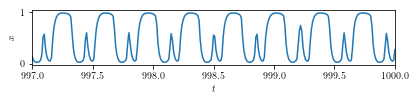

In [31]:
%%script false
plt.plot(wc_sol.t, wc_y[0])
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.xlim([997, 1000])

fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig("../figure/wc", dpi=700, bbox_inches="tight")

In [92]:
cxx, cxy, cxz = 23, -15, -10
cyx, cyy, cyz = 35, 0, 0
czx, czy, czz = 10, 0, 0
p, q, r = 3, -5, -5
τx, τy, τz = 0.015, 0.013, 0.267

In [93]:
def external(t):
    return np.array([3 + 0.02*t, -5, -5])

In [94]:
c = np.array([[cxx, cxy, cxz],
              [cyx, cyy, cyz],
              [czx, czy, czz]])
τ = np.array([τx, τy, τz])

In [95]:
def wc_dots_vary_params(t, x):
    return (-x + wc_s(np.matmul(c, x) + external(t)))/τ

In [96]:
%%time
wc_vary_p_sol = solve_ivp(wc_dots_vary_params, (0, 100), wc0, max_step=0.01, t_eval=np.linspace(25, 75, 5000), method="RK45")

CPU times: user 2.93 s, sys: 17.2 ms, total: 2.95 s
Wall time: 3.01 s


In [97]:
wc_vary_p_y = wc_vary_p_sol.y

In [98]:
wc_vary_p_sol.t.shape

(5000,)

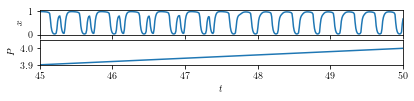

In [127]:
# %%script false
fig, [x_ax, p_ax] = plt.subplots(2, 1, sharex=True)
x_ax.plot(wc_vary_p_sol.t, wc_vary_p_y[0])
x_ax.set_ylabel("$x$")

p_ax.plot(wc_vary_p_sol.t, external(wc_vary_p_sol.t)[0])
p_ax.set_ylabel("$P$")
p_ax.set_xlabel("$t$")
p_ax.set_ylim([3.9, 4.05])
p_ax.set_xlim([45, 50])

fig.set_size_inches(*size, forward=True)
plt.savefig("../figure/wc_bifurcation", dpi=700, bbox_inches="tight")

# Epileptor

In [40]:
def epileptor_f1(x1, x2, z):
    return np.heaviside(x1, 1)*x1*(x2 - 0.6*(z - 4)**2) + np.heaviside(-x1, 0)*((x1**3) - 3*(x1**2))

In [41]:
def epileptor_f2(x1, x2):
    return np.heaviside(x2 + 0.25, 1)*6*(x2 + 0.25)

In [42]:
def epileptor(current, t, i1, i2, x0, τ0, τ2, γ):
    x1, y1, z, x2, y2, g = current
    dots = np.zeros_like(current)
    dots[0] = y1 - epileptor_f1(x1, x2, z) - z + i1
    dots[1] = 1 - 5*x1**2 - y1
    dots[2] = (4*(x1 - x0) - z)/τ0
    dots[3] = -y2 + x2 - x2**3 + i2 + 0.002*g - 0.3*(z - 3.5)
    dots[4] = (epileptor_f2(x1, x2) - y2)/τ2
    dots[5] = x1 - γ*g
    return np.hstack(dots)

In [43]:
x0 = -1.6
τ0 = 2857
τ2 = 10
i1 = 3.1
i2 = 0.01
γ = 0.01

In [58]:
ivs = np.random.normal(0, np.sqrt(0.025), 6)
ivs[1] -= 5
ivs[2] += 3

In [59]:
tmax = 2000
N = 100*tmax
t = np.linspace(0, tmax, N)

In [60]:
params = (i1, i2, x0, τ0, τ2, γ)

In [61]:
%%time
epileptor_sol = solve_ivp(fun=lambda t_in, y_in: epileptor(y_in, t_in, *params),
                          t_span=(0, tmax), t_eval=t, y0=ivs.reshape(ivs.size), method="RK45")

CPU times: user 5.88 s, sys: 78.4 ms, total: 5.96 s
Wall time: 6.38 s


In [62]:
epileptor_y = epileptor_sol.y

In [63]:
epileptor_y.shape

(6, 200000)

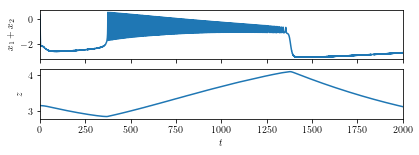

In [68]:
# %%script false
fig, [x1_ax, z_ax] = plt.subplots(2, sharex=True)
x1_ax.plot(epileptor_sol.t, epileptor_y[0] + epileptor_y[3])
z_ax.plot(epileptor_sol.t, epileptor_y[2])
z_ax.set_xlabel("$t$")
x1_ax.set_ylabel("$x_{1} + x_{2}$")
z_ax.set_ylabel("$z$")
z_ax.set_xlim([0, 2000])
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig("../figure/epileptor", dpi=700, bbox_inches="tight")

# Cat connectome

In [128]:
connectome = np.loadtxt("../../code/connectomes/cat_matrix.dat")

In [129]:
connectome.shape

(65, 65)

In [11]:
connectome[connectome == 0] = np.nan

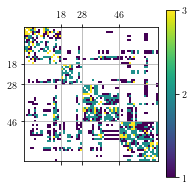

In [13]:
plt.matshow(connectome)
plt.xticks([17.5, 27.5, 45.5], [18, 28, 46])
plt.yticks([17.5, 27.5, 45.5], [18, 28, 46])
plt.grid()
plt.colorbar(ticks=[1, 2, 3])
fig = plt.gcf()
fig.set_size_inches(3, 3, forward=True)
plt.savefig("../figure/cat_matrix", dpi=700, bbox_inches="tight")

# Mouse connectome

In [3]:
def prep_masks(n, cortices):
    cortex_mask = np.zeros_like(n)
    for i, cortex in enumerate(cortices):
        cortex_mask[cortex[0]:cortex[1], cortex[0]:cortex[1]] += i + 1
    G1 = n.copy()
    G1[cortex_mask == 0] = 0
    G2 = n.copy()
    G2[cortex_mask != 0] = 0
    events = [lambda t_in, y_in, i=i: event(t_in, y_in, i)
              for i in range(n.shape[0])]
    for e in events:
        e.direction = 1.0

    return G1, G2, events

In [4]:
metadata = pd.read_excel("../../code/connectomes/mouse_meta.xlsx", sheet_name=None)

In [5]:
m = metadata["Voxel Count_295 Structures"]
m = m.loc[m["Represented in Linear Model Matrix"] == "Yes"]

In [6]:
columns = []
cortices = [[0, 0]]
for region in m["Major Region"].unique():
    i = [columns.append(acronym.replace(" ", "")) for acronym in
         m.loc[m["Major Region"] == region, "Acronym"].values]
    cortices.append([cortices[-1][-1], cortices[-1][-1] + len(i)])
cortices.remove([0, 0])

In [7]:
cortices

[[0, 12],
 [12, 23],
 [23, 61],
 [61, 70],
 [70, 81],
 [81, 102],
 [102, 122],
 [122, 130],
 [130, 143],
 [143, 168],
 [168, 175],
 [175, 210],
 [210, 213]]

In [8]:
data = pd.read_excel("../../code/connectomes/mouse.xlsx", sheet_name=None)

In [9]:
d = data["W_ipsi"]
p = data["PValue_ipsi"]
d = d[columns].reindex(columns)
p = p[columns].reindex(columns)

In [10]:
d = d.values
p = p.values

In [11]:
p[np.isnan(p)] = 1

In [12]:
d[p > 0.01] = 0

In [13]:
n = np.zeros_like(d)

In [14]:
for i in [1e-4, 1e-2, 1]:
    n[d >= i] += 1

In [15]:
G1, G2, _ = prep_masks(n, cortices)
n1 = np.count_nonzero(G1, axis=1)
n1[n1 == 0] = 1

n2 = np.count_nonzero(G2, axis=1)
n2[n2 == 0] = 1

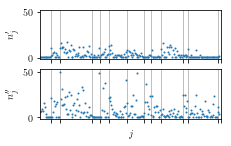

In [102]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.plot(n1, ".", markersize=2)
ax1.set_ylabel(r"$n_{j}'$")
ax1.set_xticks([cortex[1] + 0.5 for cortex in cortices])
ax1.set_xticklabels(["" for cortex in cortices])
ax1.grid(axis="x")

ax2.plot(n2, ".", markersize=2)
ax2.set_ylabel(r"$n_{j}''$")
ax2.set_xlabel("$j$")
ax2.set_xlim([-1, 214])
ax2.set_xticks([cortex[1] + 0.5 for cortex in cortices])
ax2.set_xticklabels(["" for cortex in cortices])
ax2.grid(axis="x")

fig.set_size_inches(size[0]/2, size[1] + 1)
plt.savefig("../figure/n_prime", dpi=700, bbox_inches="tight")

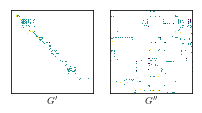

In [93]:
fig, [g1_ax, g2_ax] = plt.subplots(1, 2, sharex=True, sharey=True)
g1 = G1.copy()
g1[g1 == 0] = np.nan
g2 = G2.copy()
g2[g2 == 0] = np.nan
g1_ax.matshow(g1, aspect="equal")
g1_ax.set_xlabel("$G'$")

g2_ax.matshow(g2, aspect="equal")
g2_ax.set_xticks([])
g2_ax.set_yticks([])
g2_ax.set_xlabel("$G''$")

fig.set_size_inches(size[0]/2, size[1] + 1)
plt.savefig("../figure/g_prime", dpi=700, bbox_inches="tight")

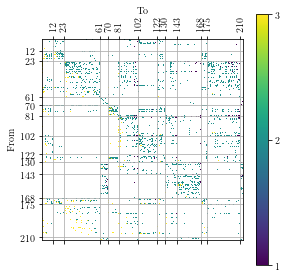

In [143]:
n[n == 0] = np.nan
plt.matshow(n)
plt.xticks([cortex[1] - 0.5 for cortex in cortices[:-1]], [cortex[1] for cortex in cortices[:-1]],
           rotation="vertical")
plt.yticks([cortex[1] - 0.5 for cortex in cortices[:-1]], [cortex[1] for cortex in cortices[:-1]])
plt.ylabel("From")
plt.xlabel("To")
plt.gca().xaxis.set_label_position("top")
plt.grid()
plt.colorbar(ticks=[1, 2, 3])
plt.gcf().set_size_inches(4.5, 4.5)
plt.savefig("../figure/n", dpi=700, bbox_inches="tight")

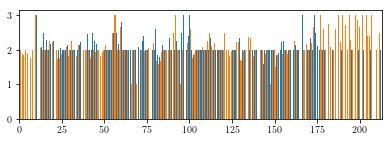

In [195]:
plt.bar(np.arange(213), np.sum(G1, axis=1)/n1, align="edge",
        width=0.5,
        label="Intra (influenced by $\\alpha$)")
plt.bar(np.arange(213) - 1/2, np.sum(G2, axis=1)/n2, align="edge",
        width=0.5,
        label="Inter (influenced by $\\beta$)")
plt.gcf().set_size_inches(*size)
plt.xlim([0, 213])
plt.savefig("../figure/g_over_n", dpi=700, bbox_inches="tight")

In [16]:
g1s = np.sum(G1, axis=1)
g2s = np.sum(G2, axis=1)

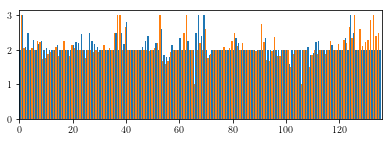

In [215]:
plt.bar(np.arange(136), g1s[(g1s != 0) & (g2s != 0)]/n1[(g1s != 0) & (g2s != 0)],
        align="edge",
       width=0.5)
plt.bar(np.arange(136) - 1/2, g2s[(g1s != 0) & (g2s != 0)]/n2[(g1s != 0) & (g2s != 0)],
        align="edge",
       width=0.5)
plt.gcf().set_size_inches(*size)
plt.xlim([0, 136])
plt.savefig("../figure/g_over_n_drop", dpi=700, bbox_inches="tight")

In [24]:
with open("../../data/high_res/hizanidis_params.pkl", "rb") as f:
    params = pickle.load(f)

In [26]:
params = params[params["max_phase"] <= 2*np.pi]

In [27]:
c = params.pivot_table(values="chimera", index="beta", columns="alpha")

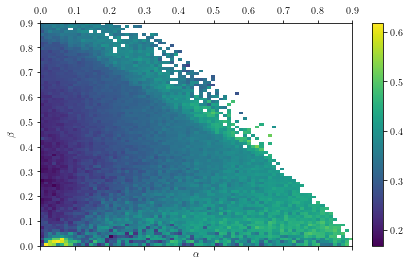

In [44]:
plt.matshow(c.values*7, origin="lower", extent=[0, 0.9, 0, 0.9], aspect="auto")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.colorbar()
fig = plt.gcf()

fig.set_size_inches(7, 4, forward=True)
plt.savefig("../figure/landscape", dpi=700, bbox_inches="tight")